# Import

In [2]:
!pip install tf-agents tensorflow gym
!pip install tf-agents[reverb]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 46.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 48.1 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.23.0-py3-none-any.whl size=697626 sha256=a3d92aa26ce9a6bcf304d44caae02f68996462cd9badf687f6a0b8729a268902
  Stored in directory: /root/.cache/pip/wheels/3d/6f/b4/3991d4fae11d0ecb0754c11cc1b4e7745012850da4efaaf0b1
Successfully built gym
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: pygame
    Found existing installation: pygame 2.6.0
    Uninstalling pygame-2.6.0:
      Successfully uninstalled pygame-2

In [1]:
!pip install pygame
!pip install opencv-python
!apt-get install python-opengl
!apt-get install ffmpeg
!apt-get install xvfb
!pip install pyglet==1.5.27
!pip install pygame_gui

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 7,813 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tf_agents import *
import time
import reverb
import tf_agents
from tf_agents.networks import actor_distribution_network
from tf_agents.networks import value_network
from tf_agents.agents.ppo import ppo_agent
from tf_agents.networks import q_network
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import gym_wrapper
from tf_agents.environments import tf_py_environment
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver
from tf_agents.metrics import tf_metrics
from tf_agents.specs import tensor_spec
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from enum import Enum
import numpy as np
import gym
from gym import spaces
import random
import os

In [41]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Environment

In [24]:
class GRID(Enum): # (valori della griglia)
  HIDDEN = -1 # '?'
  EMPTY = 0
  NEAR = range(1, 9) # il 9 è escluso
  BOMB = 9 # 'X'

class GAME_MODE(Enum): # definiamo le difficoltà, il valore indica anche il numero di bombe (escluso random)
  random = 0
  easy = 1
  medium = 2
  hard = 4
  impossible = 5

class PratoFiorito(gym.Env): # usiuamo gym.Env per fare in maniera molto semplice un environment gym
  def __init__(self, gamemode=GAME_MODE.random.value):
    super(PratoFiorito, self).__init__()
    self.game_mode = gamemode
    self.reset()

  def reset(self): # reset viene chiamato ogni volta che il gioco ricomincia
    self.steps = 0 # contiamo gli step per aumentare il reward in base ad essi, in modo da incentivare il modello
    self.first_step = False # usavamo questa variabile per capire quando avveniva il primo step, però ora il primo step avviene qui nel reset, quindi come prima observation il modello si ritrova una griglia già iniziata
    self.done = False # va a True quando il gioco finisce
    self.GRID_DIMENSION = 4 # dimensione della griglia (è quadrata)
    self.observation_space = spaces.Box(low=GRID.HIDDEN.value, high=GRID.BOMB.value, shape=(self.GRID_DIMENSION, self.GRID_DIMENSION), dtype=np.int32) # definiamo l'observation_space, che sarebbe la forma dello spazio di osservazione che il modello deve avere come input
    self.action_space = spaces.Discrete(self.GRID_DIMENSION * self.GRID_DIMENSION) # qui definiamo lo spazio di azioni (quindi il numero di celle totali)
    self.state = np.full((self.GRID_DIMENSION, self.GRID_DIMENSION), GRID.HIDDEN.value, dtype=np.int32) # in questo environment tecnicamente lo state è uguale all'observation
    self.clicked_positions = set() # teniamo memorizzati tutte le celle cliccate, così che se il modello prova a cliccarne una già cliccata, viene penalizzato
    self.first_random_step() # effetuiamo il primo step (quello di generazione della griglia), in automatico al reset dell'environment
    return self.get_observation()

  def near_bombs(self, i, j): # funzione che conta quante bombe ci sono nelle 8 celle vicine alla cella di qui passiamo le coordiante
    bombs = 0
    for h in range(i-1, i+2):
      for z in range(j-1, j+2):
        if h>=0 and h<self.GRID_DIMENSION and z>=0 and z<self.GRID_DIMENSION: # con questo if ci assicuriamo di non andare fuoiri dai bordi
          if self.state[h][z] == GRID.BOMB.value: # molto semplicemente due for che scorrono le 8 celle intorno a quella che ci interessa (i e j) e ci conta quante bombe ci sono
            bombs+=1
    return bombs

  def generate_grid(self): # -1: hidden; 0: empty; 1-8: numbers of bomb; 9: bomb
    num_bomb_placed = 0

    for i in range(self.GRID_DIMENSION): # questi due for semplicemente scorrono la griglia e piazzano casualmente delle bombe, tenendo conto di quante sono state piazzate
      for j in range(self.GRID_DIMENSION):
        if random.randint(0, 5) == 1: # allora metto una bomba
          num_bomb_placed += 1
          self.state[i][j] = GRID.BOMB.value
        else:
          self.state[i][j] = GRID.HIDDEN.value

    if num_bomb_placed == 0: # se non è stata messa nessuna bomba ovviamente rigenera
      self.generate_grid()
    if self.game_mode != GAME_MODE.random.value: # qui in base al valore della difficoltà, si assicura che siano state piazzate il numero corretto di bombe
      if num_bomb_placed < self.game_mode or num_bomb_placed > self.game_mode:
        self.generate_grid()

  def click_cell(self, y, x): # per semplificare abbiamo fatto una funzione ricorsiva che serve per scoprire molte celle insieme se c'è uno spazio vuoto
    if self.state[y][x] == GRID.BOMB.value: # si parte dal punto in cui si clicca, se c'è una bomba semplicemente si fa una returne False
      return False

    self.state[y][x] = self.near_bombs(y, x) # se invecce non c'è una bomba, si assegna allo stato di quella cella il numero di bombe vicine

    if self.state[y][x] == GRID.EMPTY.value: # se il numero di bombe vicine è pari a 0, allora scopriamo tutte le celle vuote vicine
      for h in range(y-1, y+2):
        for z in range(x-1, x+2): # con questi due for in breve stiamo richiamando click_cell() per ogni cella intorno al punto originariamente cliccato
          if h>=0 and h<self.GRID_DIMENSION and z>=0 and z<self.GRID_DIMENSION and (h != y or z != x): # qui controlliamo che non esca dalla griglia
            if self.state[h][z] == GRID.HIDDEN.value: # qui controlliamo che il valore sia ancora nascosto, se non si fa questo si cade in un loop infinito ricorsivo
              self.click_cell(h, z)

    return True


  def check_win(self):
    for i in range(self.GRID_DIMENSION):
      for j in range(self.GRID_DIMENSION):
        if self.state[i][j] == GRID.HIDDEN.value: #controlla se esistono ancora celle senza mine che siano coperte, se ci sono ovviamente non ha vinto
          return False
    return True


  def print_grid(self, debug=False):
    for row in self.state: # stampiamo riga per riga
      if not self.done and not debug:
        print(' '.join(str(element) if element != GRID.BOMB.value and element != GRID.HIDDEN.value else '?' for element in row))
      else: # l'idea era di entrare nell'else a partita finita, qui non si nascondono più le bombe ma si mostrano con 'X'
        print(' '.join(str(element) if element != GRID.BOMB.value else 'X' for element in row))
    print()

  def first_random_step(self): # faccio eseguire il primo step in maniera casuale
    self.generate_grid()
    y = random.randint(0, self.GRID_DIMENSION-1)
    x = random.randint(0, self.GRID_DIMENSION-1)
    times = 0
    while(self.near_bombs(y, x)!=0): # dentro questo while stiamo generando coordinate, e verifichiamo che la cella delle coordinate generate abbia intorno zero bombe
                                     # dopo un tot di tentativi se non troviamo nessuna cella con attorno zero bombe rigeneriamo la griglia
      y = random.randint(0, self.GRID_DIMENSION-1)
      x = random.randint(0, self.GRID_DIMENSION-1)
      times=times+1
      if(times>self.GRID_DIMENSION*self.GRID_DIMENSION/2):
        self.generate_grid()
        times=0

    self.click_cell(y, x)
    if self.check_win(): # non dovrebbe mai capitare, ma se scoprendo la prima cella la partita fosse già finita si rifà il first_step
      self.first_random_step()

  def get_observation(self):
    return np.where(self.state == GRID.BOMB.value, GRID.HIDDEN.value, self.state) # restituiamo lo state, però modificando le celle col valore BOMB dandogli il valore HIDDEN

  def step(self, action): # questa è la funzione che viene chiamata quando il modello clicca una cella
    self.steps += 1
    x, y = divmod(action, self.GRID_DIMENSION) # il valore che gli passiamo è un'intero e non due coordinate, divmod returna una tupla con il risultato della divisione intera tra action e GRID_DIMENSION ed il resto della divisione

    if self.first_step: # ormai non più usato, però questo if fa circa quello che fa la funzione first_step mantenendo le coordinate invariate
      self.first_step = False
      while(self.near_bombs(y, x)!=0):
        self.generate_grid()
      self.click_cell(y, x)
      reward = 0
    else:
      if (y, x) in self.clicked_positions: # punizione se la cella cliccata è già stata cliccata
        reward = -100
      else:
        self.clicked_positions.add((y, x)) # aggiungiamo la cella cliccata alla lista
        if not self.click_cell(y, x): # se ha colpito una bomba -200 di reward e il gioco finisce
          reward = -200
          self.done = True
        elif self.check_win(): # se ha vinto 1000 di reward e ovviamente il gioco finisce
          reward = 1000
          self.done = True
        else:
          reward = 50 + (self.steps*2) # reward scalare per aver colpito celle vuote
    return self.get_observation(), reward, self.done, {}

env = PratoFiorito(GAME_MODE.random.value)

# Dense Policy

In [50]:
env = PratoFiorito(GAME_MODE.random.value)
tf_env = tf_py_environment.TFPyEnvironment(gym_wrapper.GymWrapper(env)) # carichiamo il nostro environment con tensorflow

fc_layer_params = (256, 256)
activation_fn = tf.keras.layers.LeakyReLU()
dropout_layer_params = [0.2, 0.2]

actor_net = actor_distribution_network.ActorDistributionNetwork( # definiamo l'attore con due livelli dense da 256
  tf_env.observation_spec(),
  tf_env.action_spec(),
  fc_layer_params=fc_layer_params,
  activation_fn=activation_fn,
  dropout_layer_params=dropout_layer_params
)

value_net = value_network.ValueNetwork( # la value network ha il compito di fare da critico per le scelte dell'actor net
  tf_env.observation_spec(),
  fc_layer_params=(128, 128),
  activation_fn=activation_fn
)

initial_learning_rate = 0.0008
min_learning = 0.0001
lr_schedule  = tf.keras.optimizers.schedules.ExponentialDecay( # l'ExponentialDecay ci permette di avere un learning rate che cala in questo caso a "gradini" grazie a staircase
  initial_learning_rate=initial_learning_rate,
  decay_steps=500,
  decay_rate=0.99,
  staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
train_step_counter = tf.Variable(0)

agent = ppo_agent.PPOAgent( # abbiamo usato PPOAgent invecce di un semplice ReinforceAgent perchè il PPOAgent rende anche più stabile l'addestramento, permettendo di modificare il ratio clipping
  tf_env.time_step_spec(),
  tf_env.action_spec(),
  optimizer=optimizer,
  actor_net=actor_net,
  value_net=value_net,
  num_epochs=6,
  importance_ratio_clipping=0.2, # limita la dimensione degli agiornamenti della policy, rendendo molto più stabile l'aggiornamento
  discount_factor=0.99, # 0.99 dovrebbe essere quello di default, abbiamo provato a giocare con questo valore durante i vari training per capirne il valore ideale
  entropy_regularization=0.1, # aggiunge entropia permettendo di incentivare l'esplorazione e cercar di evitare minimi locali
  train_step_counter=train_step_counter
)

agent.initialize()

replay_buffer_capacity = 10000
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer( # replay buffer abbastanza base
  data_spec=agent.collect_data_spec,
  batch_size=tf_env.batch_size,
  max_length=replay_buffer_capacity
)

def collect_episode(environment, policy, num_episodes): # l'obbiettivo di questa funzione è di collezzionare esperienze e salvarle nel replay buffer in modo da migliorare successivamente il modello
  episode_counter = 0
  environment.reset()

  while episode_counter < num_episodes:
    time_step = environment.current_time_step()

    policy_step = policy.action(time_step)
    next_time_step = environment.step(policy_step.action)

    traj = trajectory.from_transition(time_step, policy_step, next_time_step)
    replay_buffer.add_batch(traj)

    if next_time_step.is_last():
      episode_counter += 1
      environment.reset()

def compute_avg_return(environment, policy, num_episodes=10, debug=False): # ci da una media dei reward a episodio e anche del win rate, ha una funzione di debug che ci permette di avere più informazioni su quello che sta succedendo
  total_return = 0.0
  win = 0
  for _ in range(num_episodes):
    time_step = environment.reset()
    episode_return = 0.0
    i = 1

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward

      if debug:
        print("i: ",i, "  A: ", action_step.action, "\n O: ", time_step.observation, " | \n R: ", time_step.reward)
      if time_step.reward == 1000: # è fatto in maniera un pò manuale, comunque 1000 sarebbe la ricompensa di quando vince, quindi in quel caso aumenta il numero delle vincite
        win+=1
      i+=1
      if i>16: # per evitare che entri in loop cliccando sempre la stessa cella blocco dopo un tot
        break
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0], win/num_episodes

best_avg_return = -float('inf')
num_iterations = 10000
returns = []
wins_r = []
global_steps=0 # sono gli step globali, quindi li recuperò dal checkpoint
steps=0

In [51]:
checkpoint_dir = '/content/gdrive/My Drive/pratoFiorito4x4v2(no_conv_policy)'

def save_arrays(returns, wins_r):  # queste due funzioncine ci permettono di salvare e caricare i due array con i valori di reward e win_rate
  np.savez(os.path.join(checkpoint_dir, 'training_data.npz'), returns=returns, wins_r=wins_r)
def load_arrays():
  file = os.path.join(checkpoint_dir, 'training_data.npz')
  if os.path.exists(file):
    data = np.load(file)
    return data['returns'], data['wins_r']
  else:
    return [], []

train_checkpointer = utils.common.Checkpointer(
  ckpt_dir=checkpoint_dir,
  max_to_keep=1,
  agent=agent,
  policy=agent.policy,
  global_step=train_step_counter
)
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

if latest_checkpoint: # questo if ed else è stato un po complicato da scrivere perchè non riuscivamo a trovare la funzione train_checkpointer._checkpoint.restore, con questa ora possiamo fare un restore o initialize pulito
  status = train_checkpointer._checkpoint.restore(latest_checkpoint)
  status.assert_existing_objects_matched()
  steps = train_step_counter.numpy()

  print(f"Checkpoint ripristinato da {latest_checkpoint}")
  print(f"Numero di step ripristinati: {steps}")
  print(f"Status: {status}")
else:
  train_checkpointer.initialize_or_restore()
  print("Checkpoint inizializzato")

returns, wins_r = load_arrays()
returns = returns.tolist() if isinstance(returns, np.ndarray) else [] # riconvertiamo da array numpy ad array normale
wins_r = wins_r.tolist() if isinstance(wins_r, np.ndarray) else []
if len(returns) > 0:
  global_steps = len(returns) # abbiamo usato len di returns ma potevamo anche usare steps, comunque recupera quanti step ha trainato
  print("remaining iterations: ", num_iterations-global_steps)
else:
  global_steps = 0

Checkpoint ripristinato da /content/gdrive/My Drive/pratoFiorito4x4v2(no_conv_policy)/ckpt-60000
Numero di step ripristinati: 60000
Status: <tensorflow.python.checkpoint.checkpoint.CheckpointLoadStatus object at 0x7f2770d4da50>
remaining iterations:  0


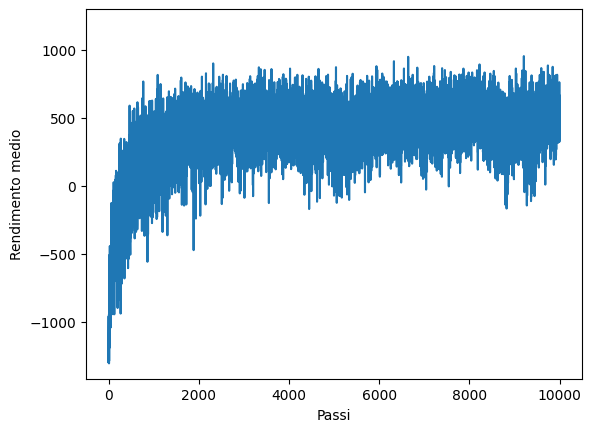

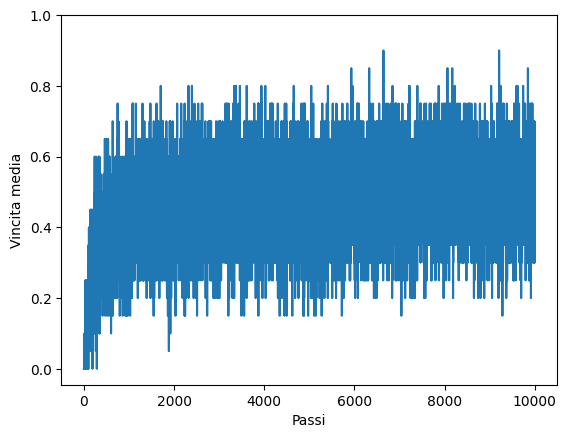

In [52]:
def draw_graph(steps, info, text, range): # questa funzione fa un semplice plot generalizzando,
                                          # draw e pause permettono (anche grazie a plt.ion() che viene chiamata dopo) di stampare in "real time" e non solo quando il programma termina
  plt.plot(steps, info)
  plt.ylabel(text)
  plt.xlabel('Passi')
  plt.ylim(top=range)
  plt.draw()
  plt.pause(0.01)

def save_and_draw(): # questa funzione stampa i due grafici dei rewards e dei win rate e poi salva checkpoint e array
  steps = range(len(returns))

  draw_graph(steps, returns, 'Rendimento medio', 1300)
  draw_graph(steps, wins_r, 'Vincita media', 1)

  train_checkpointer.save(train_step_counter)
  save_arrays(returns, wins_r)

plt.ion() # permette di usare plt in maniera interativa

tf_env.reset()
replay_buffer.clear()

collect_episode(tf_env, agent.collect_policy, num_episodes=10) # iniziamo ad inserire esperienze nel buffer

dataset = replay_buffer.as_dataset(
  num_parallel_calls=4,
  sample_batch_size=128,
  num_steps=16 # il numero di step l'abbiamo imposto a 16, all'inizio era a 2 ed era molto meno efficiente, 16 è anche troppo per la dimensione della griglia ma non è un problema
).prefetch(4)
iterator = iter(dataset)

for _ in range(num_iterations-global_steps):
  global_steps+=1
  start_time = time.time()

  collect_episode(tf_env, agent.collect_policy, num_episodes=20)

  experience, __ = next(iterator)
  train_loss = agent.train(experience)

  avg_return, win_rate = compute_avg_return(tf_env, agent.policy, num_episodes=20)
  returns.append(avg_return)
  wins_r.append(win_rate)

  if avg_return>best_avg_return: # se abbiamo un nuovo migliore stampiamo una episodio con debug
    best_avg_return=avg_return
    compute_avg_return(tf_env, agent.policy, num_episodes=1, debug=True)

  if global_steps % 100 == 0 and global_steps > 0: # ogni 100 step salvo e disegno i grafici
    save_and_draw()

  print(f'Iteration: {global_steps}, Loss: {train_loss.loss.numpy()}, avg return: {avg_return}, lr: {agent._optimizer.learning_rate.numpy()}, time: {time.time()-start_time:.2f}, win_r: {win_rate}')

save_and_draw()

plt.ioff()
plt.show()

In [53]:
avg_return, win_rate = compute_avg_return(tf_env, agent.policy, num_episodes=4000)
print(avg_return, " ", win_rate)

491.593   0.52425


# 1 Conv Policy

In [54]:
env = PratoFiorito(GAME_MODE.random.value)

tf_env = tf_py_environment.TFPyEnvironment(gym_wrapper.GymWrapper(env)) # carichiamo il nostro environment con tensorflow

conv_layer_params = ((128, 3, 1),)
fc_layer_params = (256, 256)
activation_fn = tf.keras.layers.LeakyReLU()
dropout_layer_params = [0.2, 0.2]

def preprocess(observation): # questa funzione di preprocessing ci permette di convertire i valori in float (neccessario per i livelli conv), normalizza i valori ed espande di una dimensione (sempre neccessario per i livelli conv)
  observation = tf.cast(observation, tf.float32)
  observation = observation / GRID.BOMB.value
  return tf.expand_dims(observation, -1)

preprocessing_layers = tf.keras.layers.Lambda(preprocess)

actor_net = actor_distribution_network.ActorDistributionNetwork( # definiamo l'attore con un livello conv da 128 e due livelli dense da 256
  tf_env.observation_spec(),
  tf_env.action_spec(),
  preprocessing_layers=preprocessing_layers,
  conv_layer_params=conv_layer_params,
  fc_layer_params=fc_layer_params,
  activation_fn=activation_fn,
  dropout_layer_params=dropout_layer_params
)

value_net = value_network.ValueNetwork( # la value network ha il compito di fare da critico per le scelte dell'actor net
  tf_env.observation_spec(),
  preprocessing_layers=preprocessing_layers,
  conv_layer_params=conv_layer_params,
  fc_layer_params=(128, 128),
  activation_fn=activation_fn
)

initial_learning_rate = 0.0008
min_learning = 0.0001
lr_schedule  = tf.keras.optimizers.schedules.ExponentialDecay( # l'ExponentialDecay ci permette di avere un learning rate che cala in questo caso a "gradini" grazie a staircase
  initial_learning_rate=initial_learning_rate,
  decay_steps=500,
  decay_rate=0.99,
  staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
train_step_counter = tf.Variable(0)

agent = ppo_agent.PPOAgent( # abbiamo usato PPOAgent invecce di un semplice ReinforceAgent perchè il PPOAgent rende anche più stabile l'addestramento, permettendo di modificare il ratio clipping
  tf_env.time_step_spec(),
  tf_env.action_spec(),
  optimizer=optimizer,
  actor_net=actor_net,
  value_net=value_net,
  num_epochs=6,
  importance_ratio_clipping=0.2, # limita la dimensione degli agiornamenti della policy, rendendo molto più stabile l'aggiornamento
  discount_factor=0.99, # 0.99 dovrebbe essere quello di default, abbiamo provato a giocare con questo valore durante i vari training per capirne il valore ideale
  entropy_regularization=0.1, # aggiunge entropia permettendo di incentivare l'esplorazione e cercar di evitare minimi locali
  train_step_counter=train_step_counter
)

agent.initialize()

replay_buffer_capacity = 10000
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer( # replay buffer che gestirà tutte le esperienze
  data_spec=agent.collect_data_spec,
  batch_size=tf_env.batch_size,
  max_length=replay_buffer_capacity
)

def collect_episode(environment, policy, num_episodes): # l'obbiettivo di questa funzione è di collezzionare esperienze e salvarle nel replay buffer in modo da migliorare successivamente il modello
  episode_counter = 0
  environment.reset()

  while episode_counter < num_episodes:
    time_step = environment.current_time_step()

    policy_step = policy.action(time_step)
    next_time_step = environment.step(policy_step.action)

    traj = trajectory.from_transition(time_step, policy_step, next_time_step)
    replay_buffer.add_batch(traj)

    if next_time_step.is_last():
      episode_counter += 1
      environment.reset()

def compute_avg_return(environment, policy, num_episodes=10, debug=False): # ci da una media dei reward a episodio e anche del win rate, ha una funzione di debug che ci permette di avere più informazioni su quello che sta succedendo
  total_return = 0.0
  win = 0
  for _ in range(num_episodes):
    time_step = environment.reset()
    episode_return = 0.0
    i = 1

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward

      if debug:
        print("i: ",i, "  A: ", action_step.action, "\n O: ", time_step.observation, " | \n R: ", time_step.reward)
      if time_step.reward == 1000: # è fatto in maniera un pò manuale, comunque 1000 sarebbe la ricompensa di quando vince, quindi in quel caso aumenta il numero delle vincite
        win+=1
      i+=1
      if i>16: # per evitare che entri in loop cliccando sempre la stessa cella blocco dopo un tot
        break
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0], win/num_episodes

best_avg_return = -float('inf')
num_iterations = 10000
returns = []
wins_r = []
global_steps=0 # sono gli step globali, quindi li recuperò dal checkpoint
steps=0

In [55]:
checkpoint_dir = '/content/gdrive/My Drive/pratoFiorito4x4v2(1_conv_128_policy)'

def save_arrays(returns, wins_r):  # queste due funzioncine ci permettono di salvare e caricare i due array con i valori di reward e win_rate
  np.savez(os.path.join(checkpoint_dir, 'training_data.npz'), returns=returns, wins_r=wins_r)
def load_arrays():
  file = os.path.join(checkpoint_dir, 'training_data.npz')
  if os.path.exists(file):
    data = np.load(file)
    return data['returns'], data['wins_r']
  else:
    return [], []

train_checkpointer = utils.common.Checkpointer(
  ckpt_dir=checkpoint_dir,
  max_to_keep=1,
  agent=agent,
  policy=agent.policy,
  global_step=train_step_counter
)
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

if latest_checkpoint: # questo if ed else è stato un po complicato da scrivere perchè non riuscivamo a trovare la funzione train_checkpointer._checkpoint.restore, con questa ora possiamo fare un restore o initialize pulito
  status = train_checkpointer._checkpoint.restore(latest_checkpoint)
  status.assert_existing_objects_matched()
  steps = train_step_counter.numpy()

  print(f"Checkpoint ripristinato da {latest_checkpoint}")
  print(f"Numero di step ripristinati: {steps}")
  print(f"Status: {status}")
else:
  train_checkpointer.initialize_or_restore()
  print("Checkpoint inizializzato")

returns, wins_r = load_arrays()
returns = returns.tolist() if isinstance(returns, np.ndarray) else [] # riconvertiamo da array numpy ad array normale
wins_r = wins_r.tolist() if isinstance(wins_r, np.ndarray) else []
if len(returns) > 0:
  global_steps = len(returns) # abbiamo usato len di returns ma potevamo anche usare steps, comunque recupera quanti step ha trainato
  print("remaining iterations: ", num_iterations-global_steps)
else:
  global_steps = 0

Checkpoint ripristinato da /content/gdrive/My Drive/pratoFiorito4x4v2(1_conv_128_policy)/ckpt-60000
Numero di step ripristinati: 60000
Status: <tensorflow.python.checkpoint.checkpoint.CheckpointLoadStatus object at 0x7f2770dd3250>
remaining iterations:  0


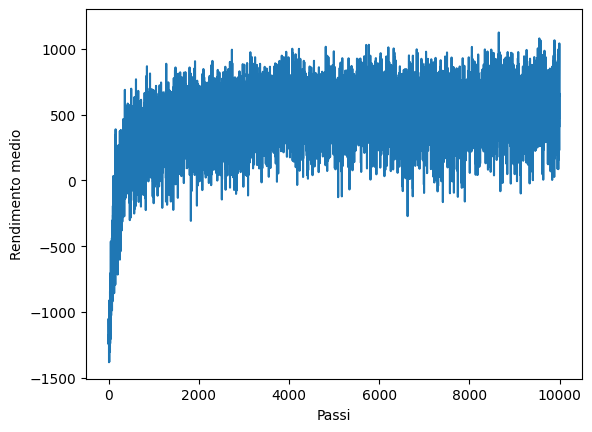

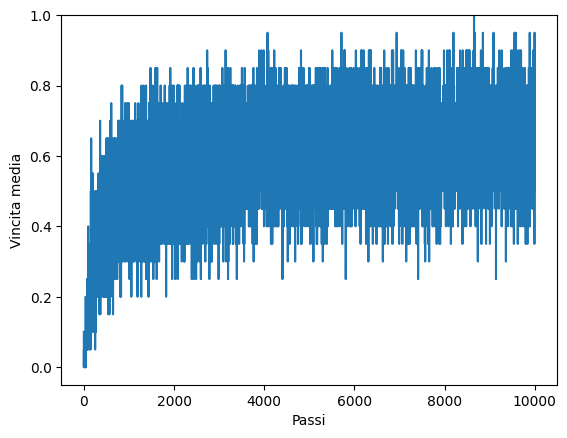

In [56]:
def draw_graph(steps, info, text, range): # questa funzione fa un semplice plot generalizzando,
                                          # draw e pause permettono (anche grazie a plt.ion() che viene chiamata dopo) di stampare in "real time" e non solo quando il programma termina
  plt.plot(steps, info)
  plt.ylabel(text)
  plt.xlabel('Passi')
  plt.ylim(top=range)
  plt.draw()
  plt.pause(0.01)

def save_and_draw(): # questa funzione stampa i due grafici dei rewards e dei win rate e poi salva checkpoint e array
  steps = range(len(returns))

  draw_graph(steps, returns, 'Rendimento medio', 1300)
  draw_graph(steps, wins_r, 'Vincita media', 1)

  train_checkpointer.save(train_step_counter)
  save_arrays(returns, wins_r)

plt.ion() # permette di usare plt in maniera interativa

tf_env.reset()
replay_buffer.clear()

collect_episode(tf_env, agent.collect_policy, num_episodes=10) # iniziamo ad inserire esperienze nel buffer

dataset = replay_buffer.as_dataset(
  num_parallel_calls=4,
  sample_batch_size=128,
  num_steps=16 # il numero di step l'abbiamo imposto a 16, all'inizio era a 2 ed era molto meno efficiente, 16 è anche troppo per la dimensione della griglia ma non è un problema
).prefetch(4)
iterator = iter(dataset)

for _ in range(num_iterations-global_steps): # se abbiamo già fatto mille step e l'obiettivo e 10mila, li sottriamo così da farne solo 9mila
  global_steps+=1
  start_time = time.time()

  collect_episode(tf_env, agent.collect_policy, num_episodes=20)

  experience, __ = next(iterator)
  train_loss = agent.train(experience)

  avg_return, win_rate = compute_avg_return(tf_env, agent.policy, num_episodes=20)
  returns.append(avg_return)
  wins_r.append(win_rate)

  if avg_return>best_avg_return: # se abbiamo un nuovo migliore stampiamo una episodio con debug
    best_avg_return=avg_return
    compute_avg_return(tf_env, agent.policy, num_episodes=1, debug=True)

  if global_steps % 100 == 0 and global_steps > 0: # ogni 100 step salvo e disegno i grafici
    save_and_draw()

  print(f'Iteration: {global_steps}, Loss: {train_loss.loss.numpy()}, avg return: {avg_return}, lr: {agent._optimizer.learning_rate.numpy()}, time: {time.time()-start_time:.2f}, win_r: {win_rate}')

save_and_draw()

plt.ioff()
plt.show()

In [57]:
avg_return, win_rate = compute_avg_return(tf_env, agent.policy, num_episodes=4000)
print(avg_return, " ", win_rate)

552.6   0.655


# More Conv Policy

In [58]:
env = PratoFiorito(GAME_MODE.random.value)
tf_env = tf_py_environment.TFPyEnvironment(gym_wrapper.GymWrapper(env)) # carichiamo il nostro environment con tensorflow

def residual_block(x, filters, kernel_size=3, activation=tf.nn.relu): # funzione classica per avere un blocco convoluzionale con una connessione residua
  x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = activation(x)
  x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  residual = tf.keras.layers.Conv2D(filters, 1, padding='same')(x)
  x = tf.keras.layers.add([x, residual])
  return activation(x)

conv_layer_params = ((128, 3, 1),)
fc_layer_params = (256, 256)
activation_fn = tf.keras.layers.LeakyReLU()
dropout_layer_params = [0.2, 0.2]

def preprocess(observation):
  observation = tf.cast(observation, tf.float32)
  observation = observation / GRID.BOMB.value
  return tf.expand_dims(observation, -1)

preprocessing_layers = tf.keras.layers.Lambda(preprocess)

def create_actor_network(input_tensor_spec, action_spec): # creaimo una rete con due blocchi residuali con conv da 128
  preprocessing_layer = tf.keras.layers.Lambda(preprocess)

  inputs = tf.keras.layers.Input(shape=input_tensor_spec.shape)
  x = preprocessing_layer(inputs)
  x = residual_block(x, 128)
  x = residual_block(x, 128)

  x = tf.keras.layers.Flatten()(x)

  for units in fc_layer_params:
      x = tf.keras.layers.Dense(units, activation=activation_fn)(x)
      x = tf.keras.layers.Dropout(0.2)(x)

  actions = tf.keras.layers.Dense(action_spec.maximum - action_spec.minimum + 1)(x)

  return tf.keras.Model(inputs=inputs, outputs=actions)

actor_net = actor_distribution_network.ActorDistributionNetwork( # in breve, stiamo passando ad ActorDistributionNetwork una rete personalizzata, contenente i blocchi residuali e i layer dense
                                                                 # questo è neccessario per via del fatto che la classe encoding_network.EncodingNetwork che viene creata all'interno di ActoDstributionNetwork non permette di personalizzare sufficientemente la rete, neanche con il padding per i conv
  tf_env.observation_spec(),
  tf_env.action_spec(),
  preprocessing_layers=preprocessing_layers,
  fc_layer_params=fc_layer_params,
  activation_fn=activation_fn,
  dropout_layer_params=dropout_layer_params,
  conv_layer_params=None,
  continuous_projection_net=create_actor_network
)

value_net = value_network.ValueNetwork( # la value network ha il compito di fare da critico per le scelte dell'actor net
  tf_env.observation_spec(),
  preprocessing_layers=preprocessing_layers,
  conv_layer_params=conv_layer_params,
  fc_layer_params=(128, 128),
  activation_fn=activation_fn
)

initial_learning_rate = 0.0008
min_learning = 0.0001
lr_schedule  = tf.keras.optimizers.schedules.ExponentialDecay( # l'ExponentialDecay ci permette di avere un learning rate che cala in questo caso a "gradini" grazie a staircase
  initial_learning_rate=initial_learning_rate,
  decay_steps=500,
  decay_rate=0.99,
  staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

train_step_counter = tf.Variable(0)
agent = ppo_agent.PPOAgent( # abbiamo usato PPOAgent invecce di un semplice ReinforceAgent perchè il PPOAgent rende anche più stabile l'addestramento, permettendo di modificare il ratio clipping
  tf_env.time_step_spec(),
  tf_env.action_spec(),
  optimizer=optimizer,
  actor_net=actor_net,
  value_net=value_net,
  num_epochs=6,
  importance_ratio_clipping=0.2, # limita la dimensione degli agiornamenti della policy, rendendo molto più stabile l'aggiornamento
  discount_factor=0.99, # 0.99 dovrebbe essere quello di default, abbiamo provato a giocare con questo valore durante i vari training per capirne il valore ideale
  entropy_regularization=0.1, # aggiunge entropia permettendo di incentivare l'esplorazione e cercar di evitare minimi locali
  train_step_counter=train_step_counter
)

agent.initialize()

replay_buffer_capacity = 10000
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer( # replay buffer che gestirà tutte le esperienze
  data_spec=agent.collect_data_spec,
  batch_size=tf_env.batch_size,
  max_length=replay_buffer_capacity
)

def collect_episode(environment, policy, num_episodes): # l'obbiettivo di questa funzione è di collezzionare esperienze e salvarle nel replay buffer in modo da migliorare successivamente il modello
  episode_counter = 0
  environment.reset()

  while episode_counter < num_episodes:
    time_step = environment.current_time_step()

    policy_step = policy.action(time_step)
    next_time_step = environment.step(policy_step.action)

    traj = trajectory.from_transition(time_step, policy_step, next_time_step)
    replay_buffer.add_batch(traj)

    if next_time_step.is_last():
      episode_counter += 1
      environment.reset()

def compute_avg_return(environment, policy, num_episodes=10, debug=False): # ci da una media dei reward a episodio e anche del win rate, ha una funzione di debug che ci permette di avere più informazioni su quello che sta succedendo
  total_return = 0.0
  win = 0
  for _ in range(num_episodes):
    time_step = environment.reset()
    episode_return = 0.0
    i = 1

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
      if debug:
        print("i: ",i, "  A: ", action_step.action, "\n O: ", time_step.observation, " | \n R: ", time_step.reward)
      if time_step.reward == 1000: # è fatto in maniera un pò manuale, comunque 1000 sarebbe la ricompensa di quando vince, quindi in quel caso aumenta il numero delle vincite
        win+=1
      i+=1
      if i>16: # per evitare che entri in loop cliccando sempre la stessa cella blocco dopo un tot
        break
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0], win/num_episodes

best_avg_return = -float('inf')
num_iterations = 10000
returns = []
wins_r = []
global_steps=0 # sono gli step globali, quindi li recuperò dal checkpoint
steps=0

In [59]:
checkpoint_dir = '/content/gdrive/My Drive/pratoFiorito4x4v2(residuali_2_layer_128)'

def save_arrays(returns, wins_r):  # queste due funzioncine ci permettono di salvare e caricare i due array con i valori di reward e win_rate
  filename = os.path.join(checkpoint_dir, 'training_data.npz')
  np.savez(filename, returns=returns, wins_r=wins_r)
def load_arrays():
  filename = os.path.join(checkpoint_dir, 'training_data.npz')
  if os.path.exists(filename):
    data = np.load(filename)
    return data['returns'], data['wins_r']
  else:
    return [], []

train_checkpointer = utils.common.Checkpointer(
  ckpt_dir=checkpoint_dir,
  max_to_keep=1,
  agent=agent,
  policy=agent.policy,
  global_step=train_step_counter
)
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

if latest_checkpoint: # questo if ed else è stato un po complicato da scrivere perchè non riuscivamo a trovare la funzione train_checkpointer._checkpoint.restore, con questa ora possiamo fare un restore o initialize pulito
  status = train_checkpointer._checkpoint.restore(latest_checkpoint)
  status.assert_existing_objects_matched()
  steps = train_step_counter.numpy()

  print(f"Checkpoint ripristinato da {latest_checkpoint}")
  print(f"Numero di step ripristinati: {steps}")
  print(f"Status: {status}")
else:
  train_checkpointer.initialize_or_restore()
  print("Checkpoint inizializzato")

returns, wins_r = load_arrays()
returns = returns.tolist() if isinstance(returns, np.ndarray) else [] # riconvertiamo da array numpy ad array normale
wins_r = wins_r.tolist() if isinstance(wins_r, np.ndarray) else []
if len(returns) > 0:
  global_steps = len(returns) # abbiamo usato len di returns ma potevamo anche usare steps, comunque recupera quanti step ha trainato
  print("remaining iterations: ", num_iterations-global_steps)
else:
  global_steps = 0

Checkpoint ripristinato da /content/gdrive/My Drive/pratoFiorito4x4v2(residuali_2_layer_128)/ckpt-60000
Numero di step ripristinati: 60000
Status: <tensorflow.python.checkpoint.checkpoint.CheckpointLoadStatus object at 0x7f27708bfbe0>
remaining iterations:  0


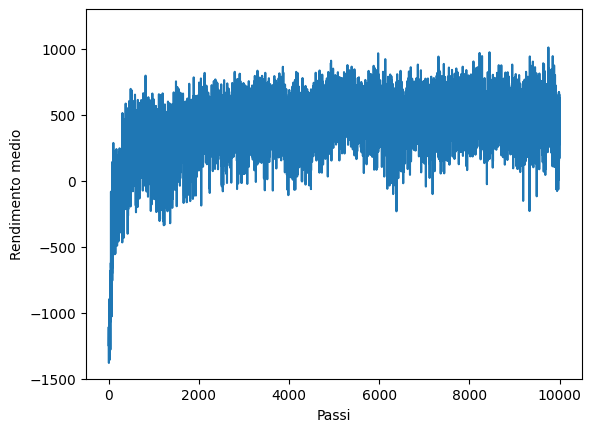

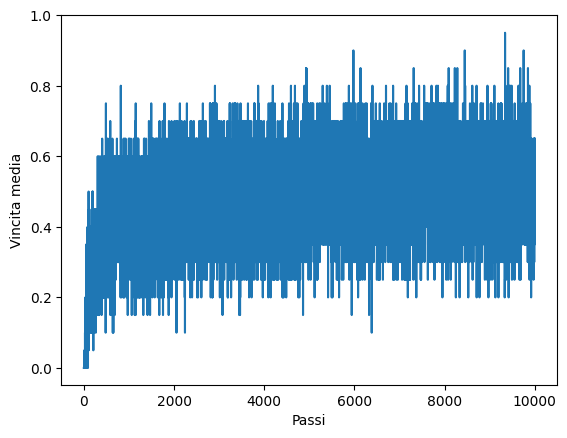

In [60]:
def draw_graph(steps, info, text, range): # questa funzione fa un semplice plot generalizzando,
                                          # draw e pause permettono (anche grazie a plt.ion() che viene chiamata dopo) di stampare in "real time" e non solo quando il programma termina
  plt.plot(steps, info)
  plt.ylabel(text)
  plt.xlabel('Passi')
  plt.ylim(top=range)
  plt.draw()
  plt.pause(0.01)

def save_and_draw(): # questa funzione stampa i due grafici dei rewards e dei win rate e poi salva checkpoint e array
  steps = range(len(returns))

  draw_graph(steps, returns, 'Rendimento medio', 1300)
  draw_graph(steps, wins_r, 'Vincita media', 1)

  train_checkpointer.save(train_step_counter)
  save_arrays(returns, wins_r)

plt.ion() # permette di usare plt in maniera interativa

tf_env.reset()
replay_buffer.clear()

collect_episode(tf_env, agent.collect_policy, num_episodes=10) # iniziamo ad inserire esperienze nel buffer

dataset = replay_buffer.as_dataset(
    num_parallel_calls=4,
    sample_batch_size=128,
    num_steps=16 # il numero di step l'abbiamo imposto a 16, all'inizio era a 2 ed era molto meno efficiente, 16 è anche troppo per la dimensione della griglia ma non è un problema
).prefetch(4)
iterator = iter(dataset)

for _ in range(num_iterations-global_steps):
  global_steps+=1
  start_time = time.time()

  collect_episode(tf_env, agent.collect_policy, num_episodes=20)

  experience, __ = next(iterator)
  train_loss = agent.train(experience)

  avg_return, win_rate = compute_avg_return(tf_env, agent.policy, num_episodes=20)
  returns.append(avg_return)
  wins_r.append(win_rate)

  if avg_return > best_avg_return: # se abbiamo un nuovo migliore stampiamo una episodio con debug
    best_avg_return=avg_return
    compute_avg_return(tf_env, agent.policy, num_episodes=1, debug=True)

  if global_steps % 100 == 0 and global_steps > 0: # ogni 100 step salvo e disegno i grafici
    save_and_draw()

  print(f'Iteration: {global_steps}, Loss: {train_loss.loss.numpy()}, avg return: {avg_return}, lr: {agent._optimizer.learning_rate.numpy()}, time: {time.time()-start_time:.2f}, win_r: {win_rate}')

save_and_draw()

plt.ioff()
plt.show()

In [61]:
avg_return, win_rate = compute_avg_return(tf_env, agent.policy, num_episodes=4000)
print(avg_return, " ", win_rate)

309.2425   0.49525


# Dense DQN

In [62]:
env = PratoFiorito(GAME_MODE.random.value)
tf_env = tf_py_environment.TFPyEnvironment(gym_wrapper.GymWrapper(env)) # carichiamo il nostro environment con tensorflow

fc_layer_params = (256, 256)
activation_fn = tf.keras.layers.LeakyReLU()
dropout_layer_params = [0.2, 0.2]

q_net = q_network.QNetwork( # definiamo la rete con due livelli dense da 256
  tf_env.observation_spec(),
  tf_env.action_spec(),
  fc_layer_params=fc_layer_params,
  activation_fn=activation_fn,
  dropout_layer_params=dropout_layer_params
)

initial_learning_rate = 0.001
min_learning = 0.0001
lr_schedule  = tf.keras.optimizers.schedules.ExponentialDecay( # l'ExponentialDecay ci permette di avere un learning rate che cala in questo caso a "gradini" grazie a staircase
  initial_learning_rate=initial_learning_rate,
  decay_steps=500,
  decay_rate=0.99,
  staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

initial_epsilon = 1.0
final_epsilon = 0.1
epsilon_decay_steps = 6000

# questa funzione ci returnerà un valore epsilon in ai valori impostati, verrà chiamata ad ogni ciclo di iterazione nel training
def compute_epsilon(steps, initial_epsilon, final_epsilon, decay_steps):
    return max(final_epsilon, initial_epsilon - (steps / decay_steps) * (initial_epsilon - final_epsilon))

train_step_counter = tf.Variable(0)
agent = dqn_agent.DqnAgent(
  tf_env.time_step_spec(),
  tf_env.action_spec(),
  optimizer=optimizer,
  q_network=q_net,
  epsilon_greedy=initial_epsilon,
  td_errors_loss_fn=common.element_wise_squared_loss,
  target_update_period=100, # ogni quanti passi di addestramento la rete target viene aggiornata (con 100 il modello è stabile)
  train_step_counter=train_step_counter
)

agent.initialize()

replay_buffer_capacity = 150000 # replay buffer molto più grande nel dqn per via della sua importanza
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_capacity
)

def collect_episode(environment, policy, num_episodes): # l'obbiettivo di questa funzione è di collezzionare esperienze e salvarle nel replay buffer in modo da migliorare successivamente il modello
  episode_counter = 0
  environment.reset()

  while episode_counter < num_episodes:
    time_step = environment.current_time_step()

    policy_step = policy.action(time_step)
    next_time_step = environment.step(policy_step.action)

    traj = trajectory.from_transition(time_step, policy_step, next_time_step)
    replay_buffer.add_batch(traj)

    if next_time_step.is_last():
      episode_counter += 1
      environment.reset()

def compute_avg_return(environment, policy, num_episodes=10, debug=False): # ci da una media dei reward a episodio e anche del win rate, ha una funzione di debug che ci permette di avere più informazioni su quello che sta succedendo
  total_return = 0.0
  win = 0
  for _ in range(num_episodes):
    time_step = environment.reset()
    episode_return = 0.0
    i = 1

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward

      if debug:
        print("i: ",i, "  A: ", action_step.action, "\n O: ", time_step.observation, " | \n R: ", time_step.reward)
      if time_step.reward == 1000: # è fatto in maniera un pò manuale, comunque 1000 sarebbe la ricompensa di quando vince, quindi in quel caso aumenta il numero delle vincite
        win+=1
      i+=1
      if i>16: # per evitare che entri in loop cliccando sempre la stessa cella blocco dopo un tot
        break
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0], win/num_episodes

best_avg_return = -float('inf')
num_iterations = 13000
returns = []
wins_r = []
global_steps=0 # sono gli step globali, quindi li recuperò dal checkpoint
steps=0

In [63]:
checkpoint_dir = '/content/gdrive/My Drive/pratoFiorito4x4v7(dense_dqn)'

def save_arrays(returns, wins_r):  # queste due funzioncine ci permettono di salvare e caricare i due array con i valori di reward e win_rate
  filename = os.path.join(checkpoint_dir, 'training_data.npz')
  np.savez(filename, returns=returns, wins_r=wins_r)
def load_arrays():
  filename = os.path.join(checkpoint_dir, 'training_data.npz')
  if os.path.exists(filename):
    data = np.load(filename)
    return data['returns'], data['wins_r']
  else:
    return [], []

train_checkpointer = utils.common.Checkpointer(
  ckpt_dir=checkpoint_dir,
  max_to_keep=1,
  agent=agent,
  policy=agent.policy,
  replay_buffer=replay_buffer, # salviamo anche il replay buffer, all'inizio come col policy based non lo salvavamo, questo però causava un periodo (circa mille iterazioni) di forte instabilità
  global_step=train_step_counter
)
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

if latest_checkpoint: # questo if ed else è stato un po complicato da scrivere perchè non riuscivamo a trovare la funzione train_checkpointer._checkpoint.restore, con questa ora possiamo fare un restore o initialize pulito
  status = train_checkpointer._checkpoint.restore(latest_checkpoint)
  status.assert_existing_objects_matched()
  steps = train_step_counter.numpy()

  print(f"Checkpoint ripristinato da {latest_checkpoint}")
  print(f"Numero di step ripristinati: {steps}")
  print(f"Status: {status}")
else:
  train_checkpointer.initialize_or_restore()
  print("Checkpoint inizializzato")

returns, wins_r = load_arrays()
returns = returns.tolist() if isinstance(returns, np.ndarray) else [] # riconvertiamo da array numpy ad array normale
wins_r = wins_r.tolist() if isinstance(wins_r, np.ndarray) else []
if len(returns) > 0:
    global_steps = len(returns) # abbiamo usato len di returns ma potevamo anche usare steps, comunque recupera quanti step ha trainato
    print("remaining iterations: ", num_iterations-global_steps)
else:
    global_steps = 0

Checkpoint ripristinato da /content/gdrive/My Drive/pratoFiorito4x4v7(dense_dqn)/ckpt-130000
Numero di step ripristinati: 130000
Status: <tensorflow.python.checkpoint.checkpoint.CheckpointLoadStatus object at 0x7f2766db6860>
remaining iterations:  0


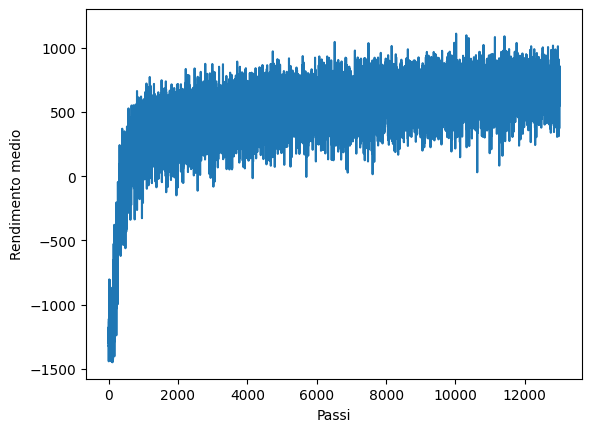

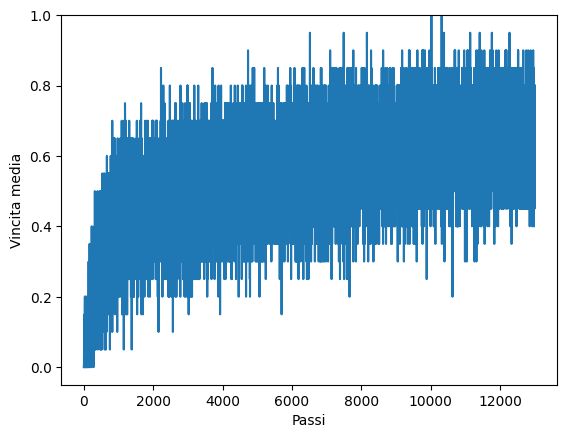

In [64]:
def draw_graph(steps, info, text, range): # questa funzione fa un semplice plot generalizzando,
                                          # draw e pause permettono (anche grazie a plt.ion() che viene chiamata dopo) di stampare in "real time" e non solo quando il programma termina
  plt.plot(steps, info)
  plt.ylabel(text)
  plt.xlabel('Passi')
  plt.ylim(top=range)
  plt.draw()
  plt.pause(0.01)

def save_and_draw(): # questa funzione stampa i due grafici dei rewards e dei win rate e poi salva checkpoint e array
  steps = range(len(returns))

  draw_graph(steps, returns, 'Rendimento medio', 1300)
  draw_graph(steps, wins_r, 'Vincita media', 1)

  train_checkpointer.save(train_step_counter)
  save_arrays(returns, wins_r)

plt.ion() # permette di usare plt in maniera interativa

collect_episode(tf_env, agent.collect_policy, num_episodes=20)

dataset = replay_buffer.as_dataset(
    num_parallel_calls=4,
    sample_batch_size=256,
    num_steps=2 # con il modello dqn il problema degli step non si è presentato, anzi, con 16 il modello era più lento e meno stabile
).prefetch(4)
iterator = iter(dataset)

for _ in range(num_iterations-global_steps):
  global_steps+=1
  start_time = time.time()
  agent.epsilon_greedy = compute_epsilon(global_steps, initial_epsilon, final_epsilon, epsilon_decay_steps)
  collect_episode(tf_env, agent.collect_policy, num_episodes=5)

  for ___ in range(10): # con il dqn facciamo più train ogni iterazione, questo aiuta al modello ad apprende meglio
    experience, __ = next(iterator)
    train_loss = agent.train(experience)

  avg_return, win_rate = compute_avg_return(tf_env, agent.policy, num_episodes=20)
  returns.append(avg_return)
  wins_r.append(win_rate)

  if avg_return>best_avg_return: # se abbiamo un nuovo migliore stampiamo una episodio con debug
    best_avg_return=avg_return
    compute_avg_return(tf_env, agent.policy, num_episodes=1, debug=True)

  if global_steps % 100 == 0 and global_steps > 0: # ogni 100 step salvo e disegno i grafici
    save_and_draw()

  print(f'Iteration: {global_steps}, Loss: {train_loss.loss.numpy()}, avg return: {avg_return}, lr: {agent._optimizer.learning_rate.numpy()}, time: {time.time()-start_time:.2f}, win_r: {win_rate}, epsilon: {agent.epsilon_greedy}')

save_and_draw()

plt.ioff()
plt.show()

In [65]:
avg_return, win_rate = compute_avg_return(tf_env, agent.policy, num_episodes=4000)
print(avg_return, " ", win_rate)

695.9595   0.676


# 1 Conv DQN

In [66]:
env = PratoFiorito(GAME_MODE.random.value)
tf_env = tf_py_environment.TFPyEnvironment(gym_wrapper.GymWrapper(env)) # carichiamo il nostro environment con tensorflow

conv_layer_params = ((128, 3, 1),)
fc_layer_params = (256, 256)
activation_fn = tf.keras.layers.LeakyReLU()
dropout_layer_params = [0.2, 0.2]

def preprocess(observation):
  observation = tf.cast(observation, tf.float32)
  observation = observation / GRID.BOMB.value
  return tf.expand_dims(observation, -1)

preprocessing_layers = tf.keras.layers.Lambda(preprocess)

q_net = q_network.QNetwork( # definiamo la rete con un livello conv da 128 e due livelli dense da 256
  tf_env.observation_spec(),
  tf_env.action_spec(),
  preprocessing_layers=preprocessing_layers,
  conv_layer_params=conv_layer_params,
  fc_layer_params=fc_layer_params,
  activation_fn=activation_fn,
  dropout_layer_params=dropout_layer_params
)

initial_learning_rate = 0.001
min_learning = 0.0001
lr_schedule  = tf.keras.optimizers.schedules.ExponentialDecay( # l'ExponentialDecay ci permette di avere un learning rate che cala in questo caso a "gradini" grazie a staircase
  initial_learning_rate=initial_learning_rate,
  decay_steps=500,
  decay_rate=0.99,
  staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

initial_epsilon = 1.0
final_epsilon = 0.1
epsilon_decay_steps = 6000

# questa funzione ci returnerà un valore epsilon in ai valori impostati, verrà chiamata ad ogni ciclo di iterazione nel training
def compute_epsilon(steps, initial_epsilon, final_epsilon, decay_steps):
  return max(final_epsilon, initial_epsilon - (steps / decay_steps) * (initial_epsilon - final_epsilon))

train_step_counter = tf.Variable(0)
agent = dqn_agent.DqnAgent(
  tf_env.time_step_spec(),
  tf_env.action_spec(),
  optimizer=optimizer,
  q_network=q_net,
  epsilon_greedy=initial_epsilon,
  td_errors_loss_fn=common.element_wise_squared_loss,
  target_update_period=100, # ogni quanti passi di addestramento la rete target viene aggiornata (con 100 il modello è stabile)
  train_step_counter=train_step_counter
)

agent.initialize()

replay_buffer_capacity = 150000 # replay buffer molto più grande nel dqn per via della sua importanza
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
  data_spec=agent.collect_data_spec,
  batch_size=tf_env.batch_size,
  max_length=replay_buffer_capacity
)

def collect_episode(environment, policy, num_episodes): # l'obbiettivo di questa funzione è di collezzionare esperienze e salvarle nel replay buffer in modo da migliorare successivamente il modello
  episode_counter = 0
  environment.reset()

  while episode_counter < num_episodes:
    time_step = environment.current_time_step()

    policy_step = policy.action(time_step)
    next_time_step = environment.step(policy_step.action)

    traj = trajectory.from_transition(time_step, policy_step, next_time_step)
    replay_buffer.add_batch(traj)

    if next_time_step.is_last():
      episode_counter += 1
      environment.reset()

def compute_avg_return(environment, policy, num_episodes=10, debug=False): # ci da una media dei reward a episodio e anche del win rate, ha una funzione di debug che ci permette di avere più informazioni su quello che sta succedendo
  total_return = 0.0
  win = 0
  for _ in range(num_episodes):
    time_step = environment.reset()
    episode_return = 0.0
    i = 1

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward

      if debug:
        print("i: ",i, "  A: ", action_step.action, "\n O: ", time_step.observation, " | \n R: ", time_step.reward)
      if time_step.reward == 1000: # è fatto in maniera un pò manuale, comunque 1000 sarebbe la ricompensa di quando vince, quindi in quel caso aumenta il numero delle vincite
        win+=1
      i+=1
      if i>16: # per evitare che entri in loop cliccando sempre la stessa cella blocco dopo un tot
        break
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0], win/num_episodes

best_avg_return = -float('inf')
num_iterations = 13000
returns = []
wins_r = []
global_steps=0 # sono gli step globali, quindi li recuperò dal checkpoint
steps=0

In [67]:
checkpoint_dir = '/content/gdrive/My Drive/pratoFiorito4x4v7(1_conv_128_dqn)'

def save_arrays(returns, wins_r):  # queste due funzioncine ci permettono di salvare e caricare i due array con i valori di reward e win_rate
  filename = os.path.join(checkpoint_dir, 'training_data.npz')
  np.savez(filename, returns=returns, wins_r=wins_r)
def load_arrays():
  filename = os.path.join(checkpoint_dir, 'training_data.npz')
  if os.path.exists(filename):
    data = np.load(filename)
    return data['returns'], data['wins_r']
  else:
    return [], []

train_checkpointer = utils.common.Checkpointer(
  ckpt_dir=checkpoint_dir,
  max_to_keep=1,
  agent=agent,
  policy=agent.policy,
  replay_buffer=replay_buffer, # salviamo anche il replay buffer, all'inizio come col policy based non lo salvavamo, questo però causava un periodo (circa mille iterazioni) di forte instabilità
  global_step=train_step_counter
)
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

if latest_checkpoint: # questo if ed else è stato un po complicato da scrivere perchè non riuscivamo a trovare la funzione train_checkpointer._checkpoint.restore, con questa ora possiamo fare un restore o initialize pulito
  status = train_checkpointer._checkpoint.restore(latest_checkpoint)
  status.assert_existing_objects_matched()
  steps = train_step_counter.numpy()

  print(f"Checkpoint ripristinato da {latest_checkpoint}")
  print(f"Numero di step ripristinati: {steps}")
  print(f"Status: {status}")
else:
  train_checkpointer.initialize_or_restore()
  print("Checkpoint inizializzato")

returns, wins_r = load_arrays()
returns = returns.tolist() if isinstance(returns, np.ndarray) else [] # riconvertiamo da array numpy ad array normale
wins_r = wins_r.tolist() if isinstance(wins_r, np.ndarray) else []
if len(returns) > 0:
    global_steps = len(returns) # abbiamo usato len di returns ma potevamo anche usare steps, comunque recupera quanti step ha trainato
    print("remaining iterations: ", num_iterations-global_steps)
else:
    global_steps = 0

Checkpoint ripristinato da /content/gdrive/My Drive/pratoFiorito4x4v7(1_conv_128_dqn)/ckpt-130000
Numero di step ripristinati: 130000
Status: <tensorflow.python.checkpoint.checkpoint.CheckpointLoadStatus object at 0x7f27706c0a90>
remaining iterations:  0


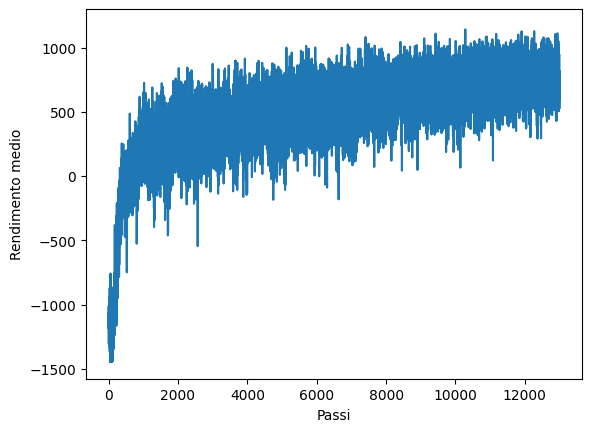

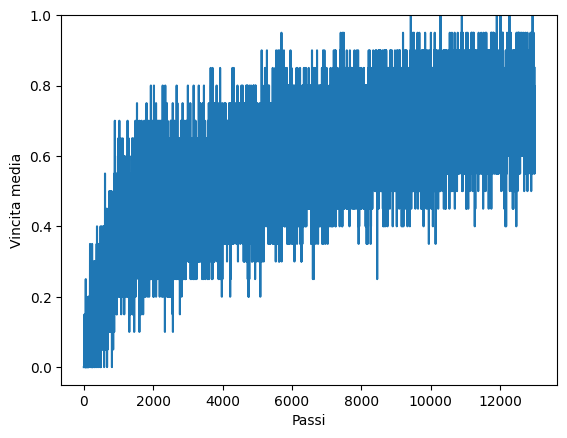

In [68]:
def draw_graph(steps, info, text, range): # questa funzione fa un semplice plot generalizzando,
                                          # draw e pause permettono (anche grazie a plt.ion() che viene chiamata dopo) di stampare in "real time" e non solo quando il programma termina
  plt.plot(steps, info)
  plt.ylabel(text)
  plt.xlabel('Passi')
  plt.ylim(top=range)
  plt.draw()
  plt.pause(0.01)

def save_and_draw(): # questa funzione stampa i due grafici dei rewards e dei win rate e poi salva checkpoint e array
  steps = range(len(returns))

  draw_graph(steps, returns, 'Rendimento medio', 1300)
  draw_graph(steps, wins_r, 'Vincita media', 1)

  train_checkpointer.save(train_step_counter)
  save_arrays(returns, wins_r)

plt.ion() # permette di usare plt in maniera interativa

collect_episode(tf_env, agent.collect_policy, num_episodes=20)

dataset = replay_buffer.as_dataset(
    num_parallel_calls=4,
    sample_batch_size=256,
    num_steps=2 # con il modello dqn il problema degli step non si è presentato, anzi, con 16 il modello era più lento e meno stabile
).prefetch(4)
iterator = iter(dataset)

for _ in range(num_iterations-global_steps):
  global_steps+=1
  start_time = time.time()

  agent.epsilon_greedy = compute_epsilon(global_steps, initial_epsilon, final_epsilon, epsilon_decay_steps)
  collect_episode(tf_env, agent.collect_policy, num_episodes=5)

  for ___ in range(10): # con il dqn facciamo più train ogni iterazione, questo aiuta al modello ad apprende meglio
    experience, __ = next(iterator)
    train_loss = agent.train(experience)

  avg_return, win_rate = compute_avg_return(tf_env, agent.policy, num_episodes=20)
  returns.append(avg_return)
  wins_r.append(win_rate)

  if avg_return>best_avg_return: # se abbiamo un nuovo migliore stampiamo una episodio con debug
    best_avg_return=avg_return
    compute_avg_return(tf_env, agent.policy, num_episodes=1, debug=True)

  if global_steps % 100 == 0 and global_steps > 0: # ogni 100 step salvo e disegno i grafici
    save_and_draw()

  print(f'Iteration: {global_steps}, Loss: {train_loss.loss.numpy()}, avg return: {avg_return}, lr: {agent._optimizer.learning_rate.numpy()}, time: {time.time()-start_time:.2f}, win_r: {win_rate}')

save_and_draw()

plt.ioff()
plt.show()

In [69]:
avg_return, win_rate = compute_avg_return(tf_env, agent.policy, num_episodes=4000)
print(avg_return, " ", win_rate)

785.8835   0.75025
